In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

def matrix_to_mesh(input_mat, num_channels, out_fpath=None, tri_indices_ico6subico2_fpath="/Users/fyzeen/FyzeenLocal/GitHub/NeuroTranslate/SurfToNetmat/code/ICAd15_schfd100/regression_tests/local_data/output/triangle_indices_ico_6_sub_ico_2.csv"):
    '''
    This function will take a numpy array of size [num_channels, 320, 153] and transform it into a shape.gii (GIFTI) file to overlay on an ico6 surface.

    Inputs 
    ----------
    input_mat: np.ndarray
        Array of shape [num_channels, 320, 153] containing the surface information for a single subject you want to make into a shape.gii file

    num_channels: int
        Number of channels in the surface (e.g., number if ICA dims)

    tri_indices_ico6subico2_fpath: str
        Path to file with mapping from 320x153 matrix to ico6 sphere vertices. This csv is also available here: https://github.com/metrics-lab/surface-vision-transformers/blob/main/utils/triangle_indices_ico_6_sub_ico_2.csv

    out_fpath: str 
        Path to which you'd like to save the generated GIFTI file. Default: None will NOT save the GIFTI file

    Outputs
    ----------
    out: nib.GiftiImage
        GIFTI image filled in with surface information stored in the input matrix
    '''

    indices_mesh_triangles = pd.read_csv(tri_indices_ico6subico2_fpath)
    mesh_vec = np.zeros([num_channels, 40962])

    for i in range(num_channels):
        for j in range(320):
            indices_to_insert = indices_mesh_triangles[str(j)].to_numpy()
            mesh_vec[i, indices_to_insert] = input_mat[i, j, :]

    out = nib.GiftiImage()
    for i in range(num_channels):
        out.add_gifti_data_array(nib.gifti.GiftiDataArray(mesh_vec[i, :].astype("float32")))

    if out_fpath is not None:
        out.to_filename(out_fpath)

    return out

def make_netmat(data, netmat_dim=100):

    # actually, this all testing so just need one such netmat I think. Since schf100 then one sub is (100*(100-1))/2 = 4950
    sing_sub = int((netmat_dim * (netmat_dim-1))/2)

    # get indeces of upptri cause all these vec netmats are upper trinagles. 
    out_mat_init = np.ones(2*sing_sub+netmat_dim).reshape(netmat_dim,netmat_dim)

    inds_uptri = np.triu_indices_from(out_mat_init,k=1) # k=1 means no diagonals
    inds_lowtri = np.tril_indices_from(out_mat_init,k=-1) # k=1 means no diagonal
    # print(len(inds_uptri), len(inds_uptri[0]), len(inds_uptri[1])) # make sure its same value as sing_sub above=n(n-1)/2
    # print(len(inds_lowtri), len(inds_lowtri[0]),len(inds_lowtri[1])) # make sure its same value as sing_sub above=n(n-1)/2
    out_mat_val = out_mat_init
    # out_mat_val[inds_uptri] = data
    out_mat_val[inds_lowtri] = data
    # Populate the upper triangle by transposing the lower triangle values
    out_mat_init[inds_uptri] = out_mat_init.T[inds_uptri]

    return out_mat_init

def show_netmats(data1, data2, plot1_title, plot2_title, netmat_dim=100):
    img1 = make_netmat(data1)
    img2 = make_netmat(data2)

    fig, axes = plt.subplots(1, 2, figsize=(11, 5))

    axes[0].imshow(img1, vmin=-10, vmax=15)
    axes[0].set_title(plot1_title)
    axes[0].axis("off")

    plot2=axes[1].imshow(img2, vmin=-1, vmax=1.5)
    axes[1].set_title(plot2_title)
    axes[1].axis("off")

    #fig.colorbar(plot2)
    plt.tight_layout()



In [86]:
path = "/Users/fyzeen/FyzeenLocal/GitHub/NeuroTranslate/SurfToNetmat/code/ICAd15_schfd100/regression_tests/local_data/output"

nontrain_L_mesh = pd.read_csv(f"{path}/nontrain_meshes_L_regression.csv")
nontrain_R_mesh = pd.read_csv(f"{path}/nontrain_meshes_R_regression.csv")
train_L_mesh = pd.read_csv(f"{path}/train_meshes_L_regression.csv")
train_R_mesh = pd.read_csv(f"{path}/train_meshes_R_regression.csv")

nontrain_netmat = pd.read_csv(f"{path}/nontrain_netmat_regression.csv")
train_netmat = pd.read_csv(f"{path}/train_netmat_regression.csv")

In [87]:
#model = "PCAConvTransformer_Large"
model = "PCAKrakLossEncoder_Large"
#model = "PCAVAEKrakLossEncoder_Shallow"
#model = "PCAVanillaKrakencoder"

train_L_pred = np.load(f"{path}/preds/train_L_{model}.npy").squeeze()
train_R_pred = np.load(f"{path}/preds/train_R_{model}.npy").squeeze()
nontrain_L_pred = np.load(f"{path}/preds/nontrain_L_{model}.npy").squeeze()
nontrain_R_pred = np.load(f"{path}/preds/nontrain_R_{model}.npy").squeeze()



In [91]:
print("Corr (Train GT, Train L Pred): " +  str(np.corrcoef(train_netmat["coefficient"], train_L_pred)[0,1]) )
print("Corr (Train GT, Train R Pred): " +  str(np.corrcoef(train_netmat["coefficient"], train_R_pred)[0,1]) )

print("Corr (Nontrain GT, Nontrain L Pred): " +  str(np.corrcoef(nontrain_netmat["coefficient"], nontrain_L_pred)[0,1]) )
print("Corr (Nontrain GT, Nontrain R Pred): " +  str(np.corrcoef(nontrain_netmat["coefficient"], nontrain_R_pred)[0,1]) )

print("Corr (Train GT, Nontrain L Pred): " +  str(np.corrcoef(train_netmat["coefficient"], nontrain_L_pred)[0,1]) )
print("Corr (Train GT, Nontrain R Pred): " +  str(np.corrcoef(train_netmat["coefficient"], nontrain_R_pred)[0,1]) )

Corr (Train GT, Train L Pred): 0.7859307771759332
Corr (Train GT, Train R Pred): 0.8364378370717037
Corr (Nontrain GT, Nontrain L Pred): 0.043443349548629065
Corr (Nontrain GT, Nontrain R Pred): 0.11574703897842391
Corr (Train GT, Nontrain L Pred): 0.4270564217355769
Corr (Train GT, Nontrain R Pred): 0.4138454989328372


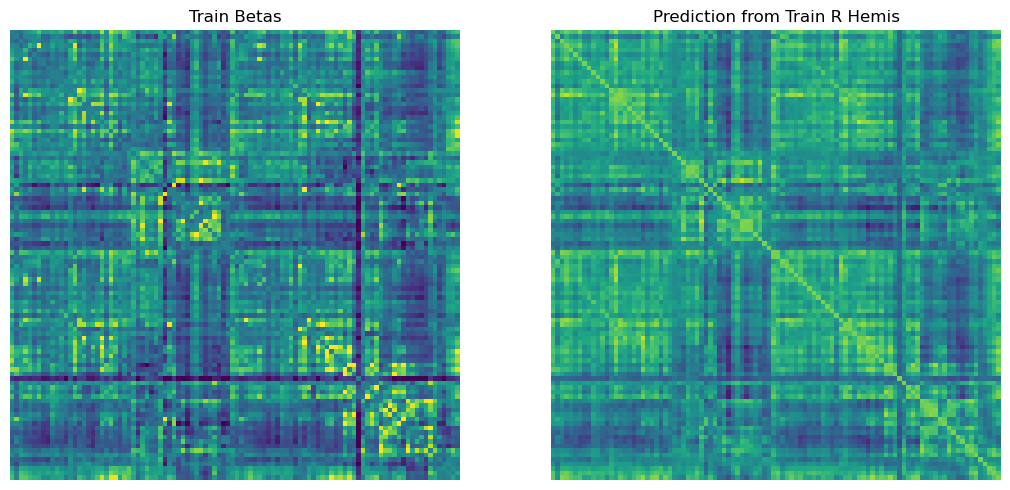

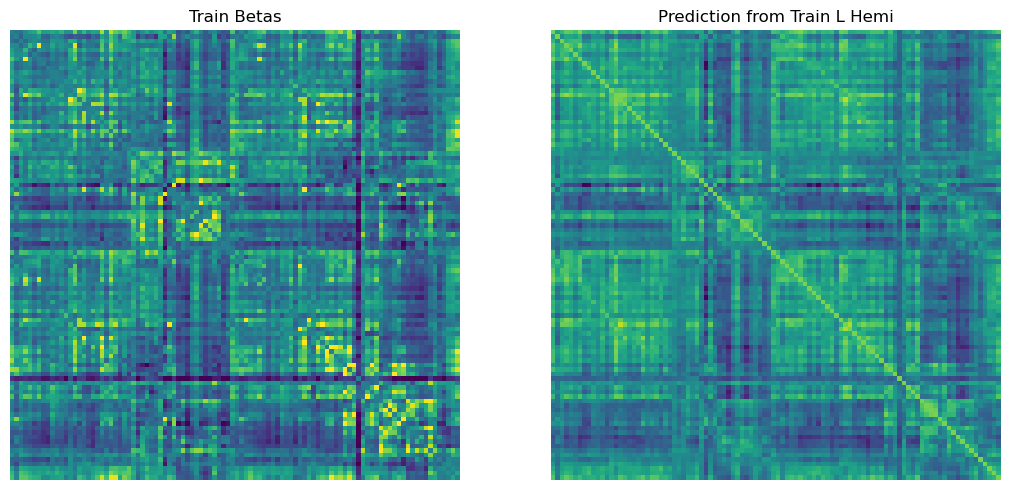

In [89]:
show_netmats(train_netmat['coefficient'], train_R_pred, "Train Betas", "Prediction from Train R Hemis")
show_netmats(train_netmat['coefficient'], train_L_pred, "Train Betas", "Prediction from Train L Hemi")

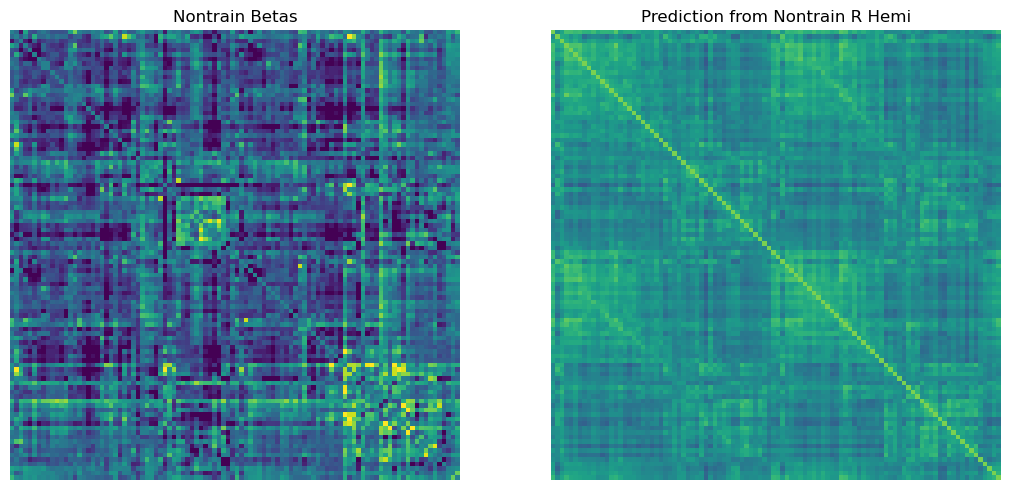

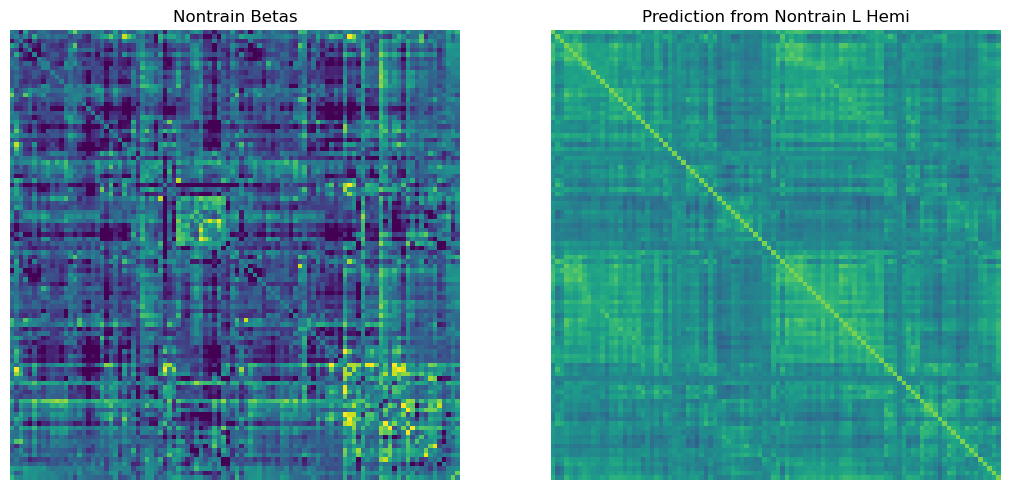

In [90]:
show_netmats(nontrain_netmat['coefficient'], nontrain_R_pred, "Nontrain Betas", "Prediction from Nontrain R Hemi")
show_netmats(nontrain_netmat['coefficient'], nontrain_L_pred, "Nontrain Betas", "Prediction from Nontrain L Hemi")

In [78]:
def plot_double_bar_graph(categories, values1, values2, labels=('Train', 'Test'),
                          title='Cognition Regression Translation Accuracy (ICA15 to Schf100)',
                          color1='#67a9cf', color2='#ef8a62'):
    """
    Plot a double bar graph.

    Parameters:
    - categories: List of category names for the x-axis.
    - values1: List of values for the first set of bars.
    - values2: List of values for the second set of bars.
    - labels: Tuple of labels for the two sets of bars.
    - title: Title of the graph.
    - color1: Color for the first set of bars.
    - color2: Color for the second set of bars.
    """
    
    # Number of categories
    n = len(categories)

    # Create an array with positions for the bars
    bar_width = 0.35  # Width of the bars
    index = np.arange(n)  # The label locations

    # Create the figure and axes
    fig, ax = plt.subplots()

    # Plot the bars for the first set of values
    ax.bar(index - bar_width/2, values1, bar_width, label=labels[0], color=color1)

    # Plot the bars for the second set of values
    ax.bar(index + bar_width/2, values2, bar_width, label=labels[1], color=color2)

    # Add labels, title, and legend
    ax.set_xlabel('Model')
    ax.set_ylabel('Correlation between GT and Pred')
    ax.set_title(title)
    ax.set_xticks(index)
    ax.set_xticklabels(categories)
    ax.legend()

    # Show the plot
    plt.show()

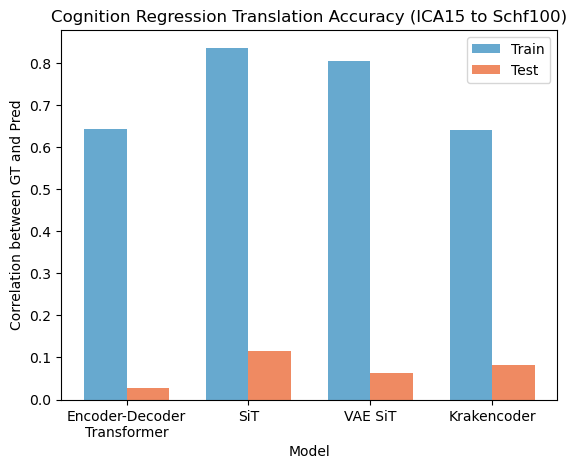

In [87]:
categories = ["Encoder-Decoder\nTransformer", "SiT", "VAE SiT", "Krakencoder"]
val1 = [0.6424062012334268, 0.8364378370717037, 0.8035253191621008, 0.6412207096236597]
val2 = [0.028388591626926935, 0.11574703897842391, 0.06404665637420674, 0.08085200223087809]

plot_double_bar_graph(categories, val1, val2)

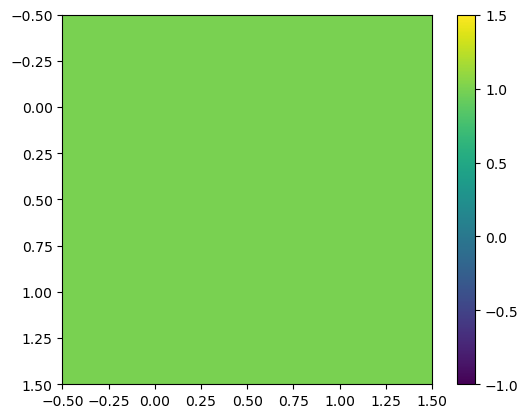

In [2]:
plt.imshow(np.ones([2,2]), vmin=-1.0, vmax=1.5)
plt.colorbar()

In [24]:
'''mesh_outpath = "/Users/fyzeen/FyzeenLocal/GitHub/NeuroTranslate/SurfToNetmat/code/ICAd15_schfd100/regression_tests/local_data/output/meshes"

matrix_to_mesh(train_L_mesh["coefficient"].to_numpy().reshape(15, 320, 153), 15, out_fpath=f"{mesh_outpath}/train_L.shape.gii")'''

'mesh_outpath = "/Users/fyzeen/FyzeenLocal/GitHub/NeuroTranslate/SurfToNetmat/code/ICAd15_schfd100/regression_tests/local_data/output/meshes"\n\nmatrix_to_mesh(train_L_mesh["coefficient"].to_numpy().reshape(15, 320, 153), 15, out_fpath=f"{mesh_outpath}/train_L.shape.gii")'